In [2]:
%pip install -e ..

Obtaining file:///home/rstudio/rl4greencrab
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for rl4greencrab (pyproject.toml) ... done
  Created wheel for rl4greencrab: filename=rl4greencrab-1.0.0-py2.py3-none-any.whl size=1073 sha256=b125839fccc41947614acd0fb477a4cd383c45dfc4c4d3f62424b7ba0fe2f36b
  Stored in directory: /tmp/pip-ephem-wheel-cache-uamcfbcc/wheels/01/b3/9b/f19820538b59bf2d6fff135754c44d6024c68184a6dac19b71
Successfully built rl4greencrab
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install gym
%pip install optuna
%pip install rl_zoo3

  Using cached gym-0.26.2.tar.gz (721 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached gym_notices-0.0.8-py3-none-any.whl.metadata (1.0 kB)
Using cached gym_notices-0.0.8-py3-none-any.whl (3.0 kB)
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827623 sha256=118f07459770258d860f7da201deb0ae140fddb03bad94e2ce1f664f11bf7417
  Stored in directory: /home/jovyan/.cache/pip/wheels/1c/77/9e/9af5470201a0b0543937933ee99ba884cd237d2faefe8f4d37
Successfully built gym
Note: you may need to restart the kernel to use updated packages.
  Using cached optuna-4.0.0-py3-none-any.whl.metadata (16 kB)
Using cached optuna-4.0.0-py3-none-any.whl (362 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached rl_zoo3-2.3.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached gymnasium-0.29.1-py3-none-any.whl.metadata (10 kB)
  Using cached pytablewriter-1.2.0-py3-

In [8]:
import numpy as np
import pandas as pd
from plotnine import ggplot, aes, geom_density, geom_line, geom_point, geom_violin, facet_grid, labs, theme, facet_wrap

from stable_baselines3 import PPO, TD3
from sb3_contrib import TQC
from stable_baselines3.common.env_util import make_vec_env

from rl4greencrab import simulator
import gym

import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
from optuna.visualization import plot_optimization_history, plot_param_importances
import gymnasium as gym
import logging
import numpy as np

from gymnasium import spaces
#from scipy.stats import normx

import sample_params
from rl4greencrab import greenCrabSimplifiedEnv, simulator
from stable_baselines3.common.evaluation import evaluate_policy
from huggingface_hub import hf_hub_download, HfApi, login

In [6]:
config = {
        'action_reward_scale': np.array([0.08, 0.08, 0.4]),
        'max_action': 3000,
        # 'env_stoch': 0.,
        'trapm_pmax': 10 * 0.1 * 2.75e-5, #2.26e-6,
        'trapf_pmax': 10 * 0.03 * 2.75e-5, #8.3e-7,
        'traps_pmax': 10 * 2.75e-5, #2.75e-5,

        'loss_a': 0.2,
        'loss_b': 5,
        'loss_c': 5,
        
        'action_reward_exponent': 10,
    }

In [12]:
gcse = greenCrabSimplifiedEnv(config)
vec_env = make_vec_env(greenCrabSimplifiedEnv, n_envs=12)
evalEnv = greenCrabSimplifiedEnv(config)

In [17]:
login()

## PPO

In [35]:
model = PPO("MlpPolicy", vec_env, verbose=0, 
            batch_size =  64, 
            n_steps = 32, 
            gamma = 0.9999, 
            learning_rate = 0.020439420278073966, 
            ent_coef = 7.676877009214456e-07, 
            clip_range =  0.1, 
            n_epochs = 20, 
            gae_lambda = 0.9, 
            max_grad_norm = 5, 
            vf_coef = 0.9694540149524578, 
            policy_kwargs = dict(net_arch=[16,16]),
            tensorboard_log="/home/rstudio/logs")
model.learn(
	total_timesteps= 100, 
	progress_bar=True,
)
model.save("ppo_gcse_short")

Output()

In [7]:
hyperparameter = {'gamma': 0.9999, 
                  'learning_rate': 0.020439420278073966, 
                  'batch_size': 16, 
                  'buffer_size': 10000, 
                  'learning_starts': 0, 
                  'train_freq': 16, 
                  'tau': 0.05, 
                  'log_std_init': -2.392885376919297, 
                  'net_arch': 'big', 
                  'n_quantiles': 31, 
                  'top_quantiles_to_drop_per_net': 1}

In [13]:
ppoAgent = PPO.load("ppo_gcse_short")
# tunningAgent = TD3.load("tunning_best_gcse")
evalEnv = greenCrabSimplifiedEnv(config)

In [19]:
api = HfApi()
api.upload_file(
        path_or_fileobj="ppo_gcse_short.zip",
        path_in_repo="ppo_gcse_short.zip",
        repo_id="jimjiang203/greencrabPPO",
        repo_type="model",
    )

ppo_gcse_short.zip:   0%|          | 0.00/141k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/jimjiang203/greencrabPPO/commit/71b09fb8baeb354a830ec9c9c1050a7680332d64', commit_message='Upload ppo_gcse_short.zip with huggingface_hub', commit_description='', oid='71b09fb8baeb354a830ec9c9c1050a7680332d64', pr_url=None, repo_url=RepoUrl('https://huggingface.co/jimjiang203/greencrabPPO', endpoint='https://huggingface.co', repo_type='model', repo_id='jimjiang203/greencrabPPO'), pr_revision=None, pr_num=None)

In [14]:
mean_rew, std_rew = evaluate_policy(ppoAgent, evalEnv)
print(f"PPO reward = {mean_rew:.5f} +/- {std_rew:.5f}")

/opt/conda/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.


PPO reward = -0.00063 +/- 0.00000


In [56]:
ppoData = simulator(env = evalEnv, agent = ppoAgent).simulate_full_named_obs_acts()
ppoDataDF = pd.DataFrame(ppoData)
ppoDataDF.head()

,t,obs0,obs1,act0,act1,act2,rew,rep
0,0,-1.000000,-1.000000,-1.0,-1.0,-0.488460,0.000000,0
1,1,-1.000000,-1.000000,-1.0,-1.0,-0.488460,-0.000005,0
2,2,-0.999896,-0.998514,-1.0,-1.0,-0.488453,-0.000010,0
3,3,-0.995126,-0.993067,-1.0,-1.0,-0.488412,-0.000014,0
4,4,-0.988741,-0.989236,-1.0,-1.0,-0.488369,-0.000019,0


<Axes: xlabel='t'>

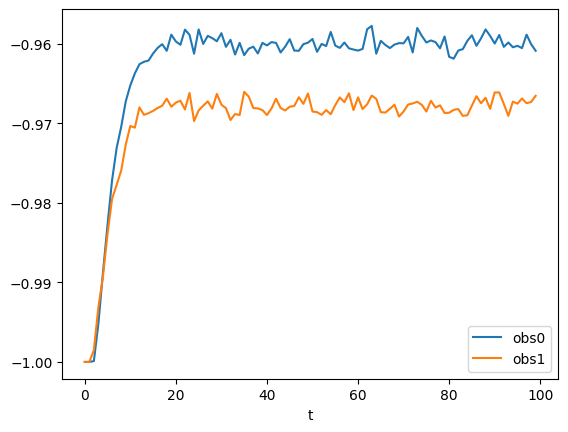

In [57]:
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['obs0', 'obs1'])

<Axes: xlabel='t'>

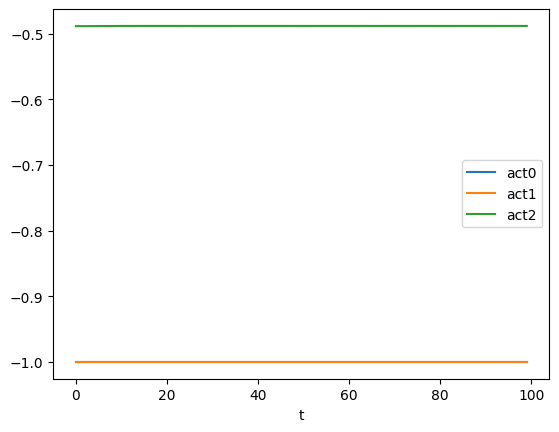

In [58]:
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['act0', 'act1', 'act2'])

## TQC 

In [ ]:
"""model = TQC("MlpPolicy", 
            vec_env, 
            verbose=0, 
            gamma= 0.9999, 
            learning_rate = 0.020439420278073966, 
            batch_size = 16, 
            buffer_size = 10000, 
            learning_starts= 0, 
            train_freq = 16, 
            tau = 0.05, 
            top_quantiles_to_drop_per_net = 1)"""
model = TQC("MlpPolicy", vec_env, verbose=0, tensorboard_log="/home/rstudio/logs")
model.learn(
	total_timesteps=500_000, 
	progress_bar=True
)
model.save("tqc_gcse_short")

In [13]:
tqcAgent = TQC.load("tqc_gcse_short")
mean_rew, std_rew = evaluate_policy(tqcAgent, evalEnv)
print(f"TQC reward = {mean_rew:.5f} +/- {std_rew:.5f}")

/opt/conda/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.


TQC reward = -73.83890 +/- 0.61748


(   t      obs0      obs1      act0      act1      act2       rew  rep
 0  0 -1.000000 -1.000000 -0.936245 -0.945725  0.744393  0.000000    0
 1  1 -1.000000 -1.000000 -0.936245 -0.945725  0.744393 -1.019067    0
 2  2 -0.999943 -0.998948 -0.936245 -0.945725  0.744393 -2.038134    0
 3  3 -0.997680 -0.997272 -0.936245 -0.945725  0.744393 -3.057201    0
 4  4 -0.996055 -0.995962 -0.936245 -0.945725  0.744393 -4.076268    0,
 <Axes: xlabel='t'>,
 <Axes: xlabel='t'>)

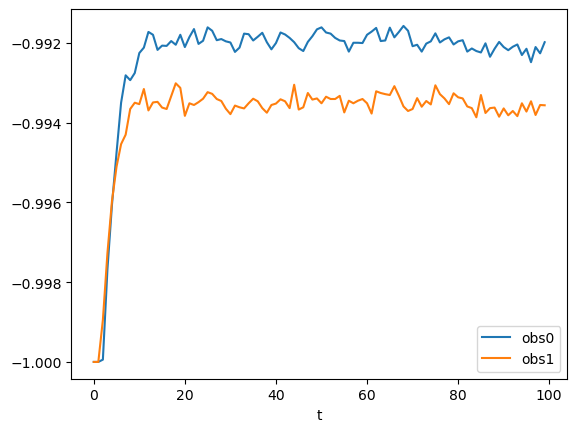

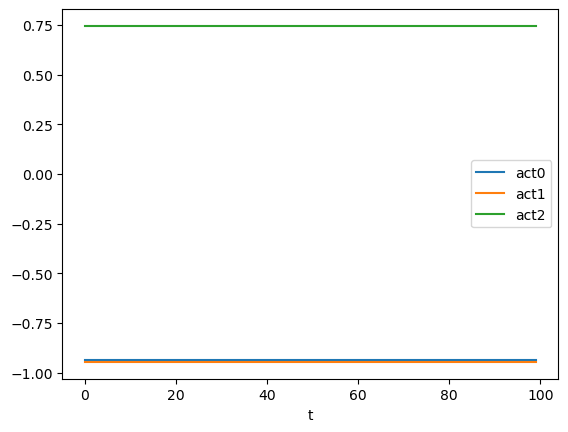

In [11]:
tqcData = simulator(env = evalEnv, agent = tqcAgent).simulate_full_named_obs_acts()
tqcDataDF = pd.DataFrame(tqcData)
(
    tqcDataDF.head(),
    tqcDataDF[tqcDataDF.rep == 0].plot(x='t', y =['obs0', 'obs1']),
    tqcDataDF[tqcDataDF.rep == 0].plot(x='t', y =['act0','act1','act2']),
)

## TD3

In [5]:
model = TD3("MlpPolicy", gcse, verbose=0, tensorboard_log="/home/rstudio/logs")
model.learn(
	total_timesteps=250_000, 
	progress_bar=True,
)
model.save("td3_gcse_short")

Output()

In [20]:
api.upload_file(
        path_or_fileobj="td3_gcse_short.zip",
        path_in_repo="td3_gcse_short.zip",
        repo_id="jimjiang203/greencrabPPO",
        repo_type="model",
    )

td3_gcse_short.zip:   0%|          | 0.00/5.94M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/jimjiang203/greencrabPPO/commit/75543b3f463de3fd2905a79aff0c1d59cb2fa354', commit_message='Upload td3_gcse_short.zip with huggingface_hub', commit_description='', oid='75543b3f463de3fd2905a79aff0c1d59cb2fa354', pr_url=None, repo_url=RepoUrl('https://huggingface.co/jimjiang203/greencrabPPO', endpoint='https://huggingface.co', repo_type='model', repo_id='jimjiang203/greencrabPPO'), pr_revision=None, pr_num=None)

In [52]:
td3Agent = TD3.load("td3_gcse_short")
mean_rew, std_rew = evaluate_policy(td3Agent, evalEnv)
print(f"TD3 reward = {mean_rew:.5f} +/- {std_rew:.5f}")

/opt/venv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.


TD3 reward = -0.00151 +/- 0.00000


(<Axes: xlabel='t'>, <Axes: xlabel='t'>)

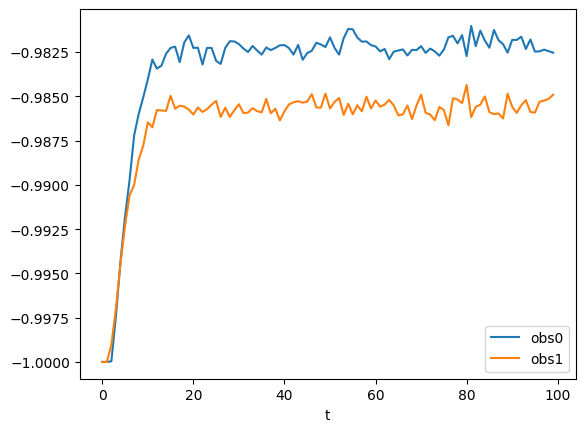

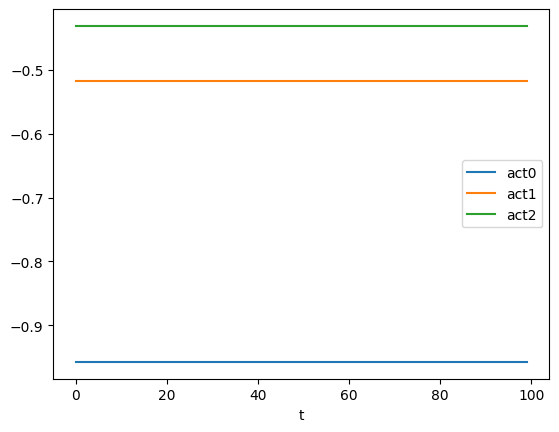

In [50]:
td3Data = simulator(env = evalEnv, agent = td3Agent).simulate_full_named_obs_acts()
td3DataDF = pd.DataFrame(td3Data)
(
    td3DataDF[td3DataDF.rep == 0].plot(x='t', y =['obs0', 'obs1']),
    td3DataDF[td3DataDF.rep == 0].plot(x='t', y =['act0', 'act1', 'act2']),
)

## Constant Action

In [14]:
import numpy as np
import pandas as pd
from plotnine import (
    ggplot, aes, geom_density, geom_line, geom_point, 
    geom_violin, facet_grid, labs, theme, facet_wrap,
)
from rl4greencrab import greenCrabEnv, greenCrabSimplifiedEnv
from rl4greencrab import simulator, constAction, multiConstAction, constActionNatUnits, evaluate_agent
from skopt import gp_minimize, gbrt_minimize 
from skopt.plots import plot_convergence, plot_objective

In [19]:
def evaluateConstAct(x):
    config = {
        'action_reward_scale': np.array([0.08, 0.08, 0.4]),
        'max_action': 3000,
        # 'env_stoch': 0.,
        'trapm_pmax': 10 * 0.1 * 2.75e-5, #2.26e-6,
        'trapf_pmax': 10 * 0.03 * 2.75e-5, #8.3e-7,
        'traps_pmax': 10 * 2.75e-5, #2.75e-5,

        'loss_a': 0.2,
        'loss_b': 5,
        'loss_c': 5,
        
        'action_reward_exponent': 10,
    }
    env = greenCrabEnv(config=config)
    agent = multiConstAction(env=env, action=np.array(x))
    # rewards = simulator(env, agent).simulate()
    # out = np.mean(rewards)
    m_reward = evaluate_agent(agent=agent, ray_remote=True).evaluate(n_eval_episodes=200)
    print(m_reward)
    return - m_reward

In [ ]:
%%time
max_action = 3000
res = gp_minimize(evaluateConstAct, 3*[(0.0, max_action)], n_calls = 100, verbose=True)
res.x

In [20]:
evaluateConstAct(
    [477, 516, 644]
)
# [0.0, 3.3306690738754696e-13, 0.0]

-2.837943099992774e-05


2.837943099992774e-05

In [30]:
ep_rew = 0
for i in range(100):
    observation, reward, terminated, truncated, info = gcse.step(np.array([0.0, 3.3306690738754696e-13, 0.0]))
    ep_rew += reward

In [31]:
ep_rew

-99981.84222500451